![Event Prediction using Case-Based Reasoning over Knowledge Graphs](../images/titleslide.png)

In this demonstration, we present EvCBR, a case-based reasoning model for knowledge-driven
event prediction.
We will first load up a model,
with some preprocessing already performed on the KG, and demonstrate two examples for
predicting properties about the Effect of a new Cause event.

In [1]:
from evcbr import EvCBR
from utils import *
from rdflib import Graph, Literal
import random
from IPython.display import Image

In [2]:
full_kg_file = (DATA_DIR / "demo_kg"/"wikidata_cc_full_3_hop.nt").resolve()
model_kg_file = (DATA_DIR / "demo_kg"/"wikidata_cc_nolit_3_hop.nt").resolve()

preprocessed_sim_dir = (DATA_DIR / "pp_wiki_full").resolve()
full_kg = Graph()
full_kg.bind("wd", WD)
full_kg.bind("wdt", WDT)
full_kg.parse(str(full_kg_file), format='nt')
# remove literals form the kg to use in the model
model_kg = Graph()
model_kg.parse(str(model_kg_file), format='nt')
add_haseffect_relations(model_kg)

model = EvCBR(KG=model_kg, preprocessed_data_dir=preprocessed_sim_dir)

Our first example will be to predict the effect of a new Megathrust Earthquake event that occurs in Japan.
First we'll query the KG to search for the appropriate URIs to use for our inputs of the new event.

In [3]:
query_results = full_kg.query("""
select ?qid ?label
where {
    ?qid rdfs:label ?label.
    filter( regex(?label, "megathrust earthquake" ))
}
""")
print("Matching results for Megathrust Earthquake")
for res in query_results:
    print(f"{res.qid} - {res.label}")

Matching results for Megathrust Earthquake
http://www.wikidata.org/entity/Q727990 - megathrust earthquake


In [4]:
query_results = full_kg.query("""
select ?qid ?label
where {
    ?qid rdfs:label ?label.
    filter( regex(?label, "Japan" ))
}
order by strlen(str(?label))
""")
# There are a lot of matching results for Japan, so we'll just sort by the length of the label
# and show a few of them here
print("Matching results for Japan")
for res in list(query_results)[:3]:
    print(f"{res.qid} - {res.label}")
print(f"{len(query_results)-3} more results results ommitted")

Matching results for Japan
http://www.wikidata.org/entity/Q17 - Japan
http://www.wikidata.org/entity/Q5287 - Japanese
http://www.wikidata.org/entity/Q58893412 - Japanese
185 more results results ommitted


We'll select WD:Q17 as our entity for Japan, and WD:Q727990 as our entity for the Megathrust Earthquake class.
We'll make our new event as an entity with a "instanceOf" relation pointing to the Megathrust Earthquake class, and
"country" relation to Japan.

In [5]:
p_instanceOf = WDT["P31"] # instanceOf
p_country = WDT["P17"] # country
ent_instanceOf1 = WD["Q727990"] # Megathrust Earthquake
ent_country1 = WD["Q17"] # Japan

# set up a dummy node for a new "megathrust earthquake in Japan" event
anon_node1 = WD["ex1"]
japan_eq_pred_triples = [
    (anon_node1, p_instanceOf, ent_instanceOf1),
    (anon_node1, p_country, ent_country1)
]

# predict the instanceOf and country of the effect event
predict_properties = [p_instanceOf, p_country]

Run the EvCBR prediction method. We can specify parameters such as how many hops in the KG to explore, how many
cases to retrieve, and how many paths to sample.

We produce two predictions here: one for our basic prediction method, and a second to produce "refined" predictions.
Intuitively, our basic prediction method produces initial predictions about the properties of the new Effect event,
while the refinement method aims to improve the predictions based on how well they can be used to "predict" the
input properties used to produce them.

In [6]:
# many methods involve random choices, so set seed for consistent demo
random.seed(2023)

# set up and run prediction
model.set_forecast_triples(japan_eq_pred_triples)
forward_res1 = model.forecast_effects(
    triples_for_inductive_forecast=japan_eq_pred_triples,
    dummy_target_uri=anon_node1,
    forecast_relations=predict_properties,
    max_hops=3, sample_case_count=4,
    sample_case_cov_count=0, sample_path_count=180,
    print_info=False,
    precomputed_similar_cases=None,
    dummy_connecting_relation_uri=WDT_HASEFFECT,
    prevent_inverse_paths=False,
    save_path_info=True
)
model.clean_forecast_triples()
reverse_res1 = model.forecast_effect_reverse_predictions(
                prop_forecasts=forward_res1.property_entity_support,
                dummy_target_uri=anon_node1,
                triples_for_inductive_forecast=japan_eq_pred_triples,
                similar_case_effects=forward_res1.similar_cause_effect_pairs,
                max_hops=3,sample_path_count=180,
                prevent_inverse_paths=False
            )

Here we show some visualizations of 4 cases from the KG that were used to make our prediction. Cases are selected
based on factors such as the similarity of each property and the relative importance of properties.

The causes connection relation is `P1542`.

1896 Sanriku earthquake -> 1896 Rikuu  earthquake


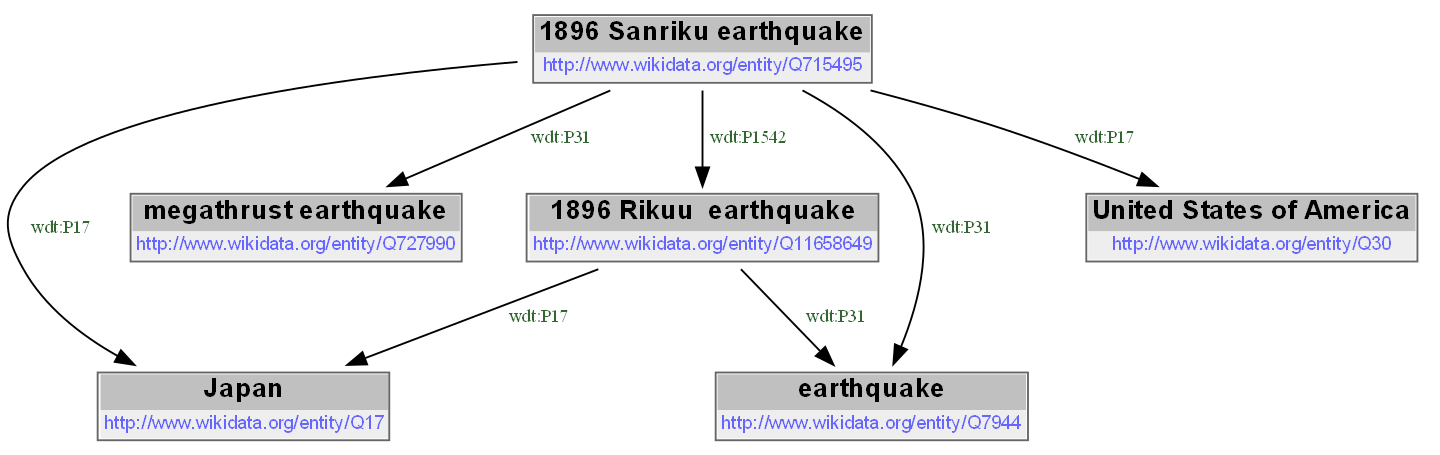

2011 Tōhoku earthquake and tsunami -> 2011 northern Nagano earthquake


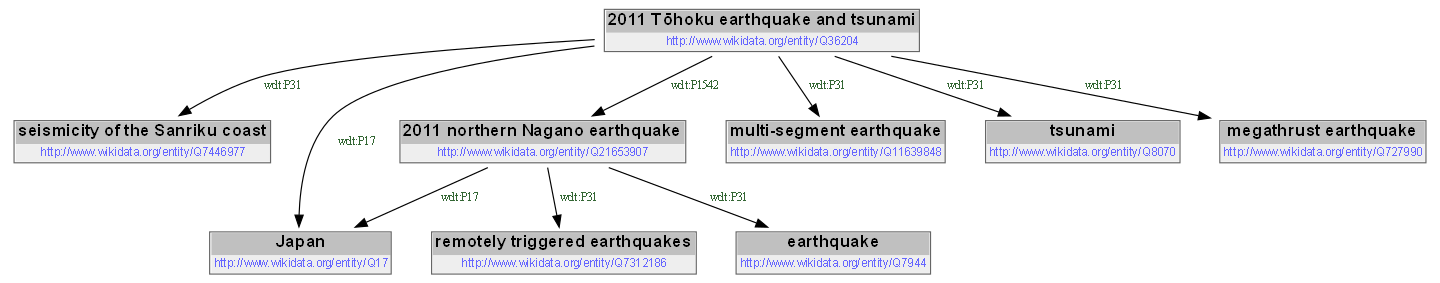

2004 Indian Ocean earthquake -> 2004 Sri Lanka tsunami-rail disaster


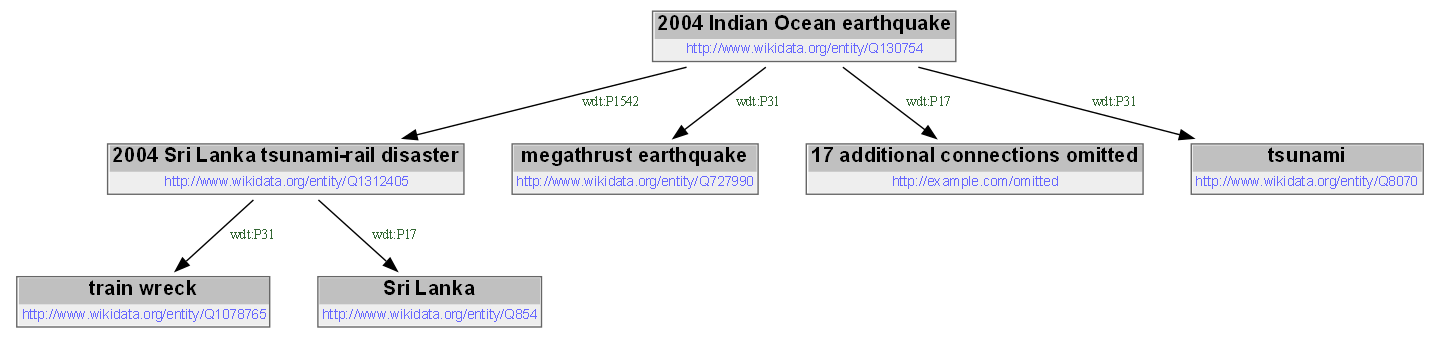

Isshi Incident -> Taika Reform


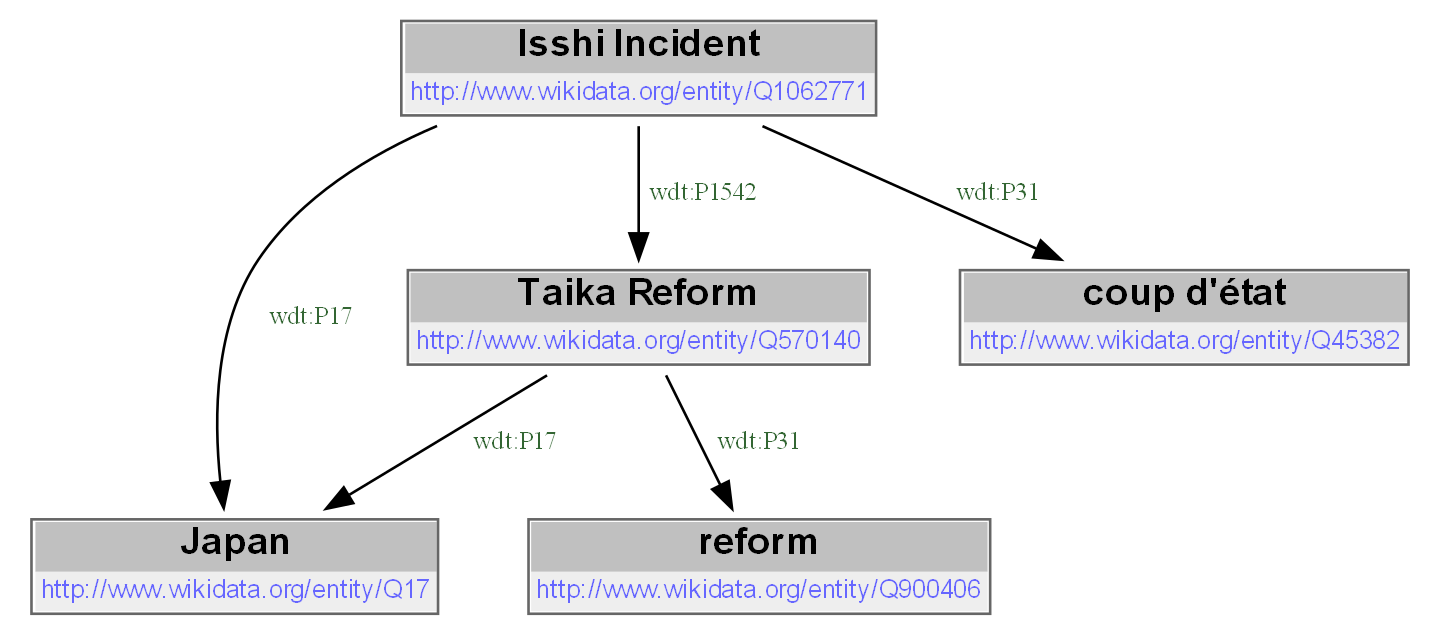

In [7]:
from visualizations.vis_cases import *
supporting_cases1 = forward_res1.similar_cause_effect_pairs
for i in range(4):
    print(full_kg.value(subject=supporting_cases1[i].cause, predicate=RDFS.label), "->",
          full_kg.value(subject=supporting_cases1[i].effect, predicate=RDFS.label))
    imname = f'eq_{i}.png'
    visualize_supporting_case(c=supporting_cases1[i], kg=full_kg, connecting_prop=WDT_HASEFFECT,
                         cause_props=[p_instanceOf, p_country], effect_props=[p_instanceOf, p_country],
                              imname=imname,
                              workaround_country=ent_country1)

The top predictions for the new Effect event's `country` and `instanceOf` properties using the basic prediction
method are as follows:

In [8]:
print("Top predictions for the effect event's country relation")
for (prediction, supp) in list(forward_res1.property_entity_support[p_country].items())[:7]:
    ent_label = full_kg.value(subject=prediction, predicate=RDFS.label)
    print(f"{ent_label} ({prediction})")
print("====")
print("Top predictions for the effect event's instanceOf relation")
for (prediction, supp) in list(forward_res1.property_entity_support[p_instanceOf].items())[:7]:
    ent_label = full_kg.value(subject=prediction, predicate=RDFS.label)
    print(f"{ent_label} ({prediction})")

Top predictions for the effect event's country relation
Japan (http://www.wikidata.org/entity/Q17)
United States of America (http://www.wikidata.org/entity/Q30)
Taiwan (http://www.wikidata.org/entity/Q865)
United Kingdom (http://www.wikidata.org/entity/Q145)
Mexico (http://www.wikidata.org/entity/Q96)
Italy (http://www.wikidata.org/entity/Q38)
Somalia (http://www.wikidata.org/entity/Q1045)
====
Top predictions for the effect event's instanceOf relation
earthquake (http://www.wikidata.org/entity/Q7944)
megathrust earthquake (http://www.wikidata.org/entity/Q727990)
volcano tectonic earthquake (http://www.wikidata.org/entity/Q3541302)
multi-segment earthquake (http://www.wikidata.org/entity/Q11639848)
remotely triggered earthquakes (http://www.wikidata.org/entity/Q7312186)
earthquake in Japan (http://www.wikidata.org/entity/Q3510594)
tsunami (http://www.wikidata.org/entity/Q8070)


The top predictions based on our refinement method are:

In [9]:
print("Refined predictions for the effect event's country relation")
for (prediction, supp) in reverse_res1.property_prediction_support[p_country][:7]:
    ent_label = full_kg.value(subject=prediction, predicate=RDFS.label)
    print(f"{ent_label} ({prediction})")
print("====")
print("Refined predictions for the effect event's instanceOf relation")
for (prediction, supp) in reverse_res1.property_prediction_support[p_instanceOf][:7]:
    ent_label = full_kg.value(subject=prediction, predicate=RDFS.label)
    print(f"{ent_label} ({prediction})")

Refined predictions for the effect event's country relation
Japan (http://www.wikidata.org/entity/Q17)
Fukushima Prefecture (http://www.wikidata.org/entity/Q71707)
United States of America (http://www.wikidata.org/entity/Q30)
Taiwan (http://www.wikidata.org/entity/Q865)
Futaba (http://www.wikidata.org/entity/Q1023949)
Kagoshima Prefecture (http://www.wikidata.org/entity/Q15701)
Mexico (http://www.wikidata.org/entity/Q96)
====
Refined predictions for the effect event's instanceOf relation
earthquake (http://www.wikidata.org/entity/Q7944)
city of Japan (http://www.wikidata.org/entity/Q494721)
megathrust earthquake (http://www.wikidata.org/entity/Q727990)
railway line (http://www.wikidata.org/entity/Q728937)
dissolved municipality of Japan (http://www.wikidata.org/entity/Q18663566)
multi-segment earthquake (http://www.wikidata.org/entity/Q11639848)
prefecture of Japan (http://www.wikidata.org/entity/Q50337)


We can see some a mixture of some good and bad predictions from both methods. In general the refined predictions
appear to do a better job of predicting that an effect will occur in Japan, specific areas in Japan, or countries
that are geographically/politically close to Japan.

The refinement method sometimes leads to some less desirable predictions for the effect's instanceOf,
such as classes that aren't types of events. Since several of the similar cases used to make predictions were
events where a megathrust earthquake caused the occurrence of more earthquakes, we can see how many of our predictions
in turn are different varieties of earthquakes.

Next, we'll look at an example for predicting the effects of an ongoing event, specifically the
recent Protests in Iran.

We once again will perform predictions using some minimal input properties.

In [10]:
query_results = full_kg.query("""
select ?qid ?label
where {
    ?qid rdfs:label ?label.
    filter( regex(?label, "protest" ))
}
order by strlen(str(?label))
""")
print("Matching results for Protest")
for res in list(query_results)[:3]:
    print(f"{res.qid} - {res.label}")
print(f"{len(query_results)-3} more results results ommitted")

Matching results for Protest
http://www.wikidata.org/entity/Q273120 - protest
http://www.wikidata.org/entity/Q829147 - protest song
http://www.wikidata.org/entity/Q15631336 - protest march
47 more results results ommitted


In [11]:
query_results = full_kg.query("""
select ?qid ?label
where {
    ?qid rdfs:label ?label.
    filter( regex(?label, "Iran" ))
}
order by strlen(str(?label))
""")
# There are a lot of matching results for Japan, so we'll just sort by the length of the label
# and show a few of them here
print("Matching results for Iran")
for res in list(query_results)[:3]:
    print(f"{res.qid} - {res.label}")
print(f"{len(query_results)-3} more results results ommitted")

Matching results for Iran
http://www.wikidata.org/entity/Q794 - Iran
http://www.wikidata.org/entity/Q63214936 - Iranun
http://www.wikidata.org/entity/Q3409301 - Irantxe
66 more results results ommitted


We'll select WD:Q794 as our entity for Iran, and WD:Q273120 as our entity for the protest class.

In [12]:
# PROTEST in IRAN example

p_instanceOf = WDT["P31"] # instanceOf
p_country = WDT["P17"] # country
ent_instanceOf2 = WD["Q273120"] # Protest
ent_country2 = WD["Q794"] # Iran

# set up a dummy node for a new "protest in Iran" event
anon_node2 = WD["ex2"]
iran_protest_pred_triples = [
    (anon_node2, p_instanceOf, ent_instanceOf2),
    (anon_node2, p_country, ent_country2)
]

# predict the instanceOf and country of the effect event
predict_properties = [p_instanceOf, p_country]

In [13]:
# many methods involve random choices, so set seed for consistent demo
random.seed(2022)

# set up and run prediction
model.set_forecast_triples(iran_protest_pred_triples)
forward_res2 = model.forecast_effects(
    triples_for_inductive_forecast=iran_protest_pred_triples,
    dummy_target_uri=anon_node2,
    forecast_relations=predict_properties,
    max_hops=3, sample_case_count=5,
    sample_case_cov_count=2, sample_path_count=180,
    print_info=False,
    precomputed_similar_cases=None,
    dummy_connecting_relation_uri=WDT_HASEFFECT,
    prevent_inverse_paths=False,
    save_path_info=True
)
model.clean_forecast_triples()
reverse_res2 = model.forecast_effect_reverse_predictions(
                prop_forecasts=forward_res2.property_entity_support,
                dummy_target_uri=anon_node2,
                triples_for_inductive_forecast=iran_protest_pred_triples,
                similar_case_effects=forward_res2.similar_cause_effect_pairs,
                max_hops=3,sample_path_count=180,
                prevent_inverse_paths=False
            )


We once again visualize the cases retrieved to make our prediction. Recall that `P1542` is the causal relation
`hasEffect` in our dataset.

Bahraini protests of 2011 -> Destruction of Shia mosques during the 2011 Bahraini uprising


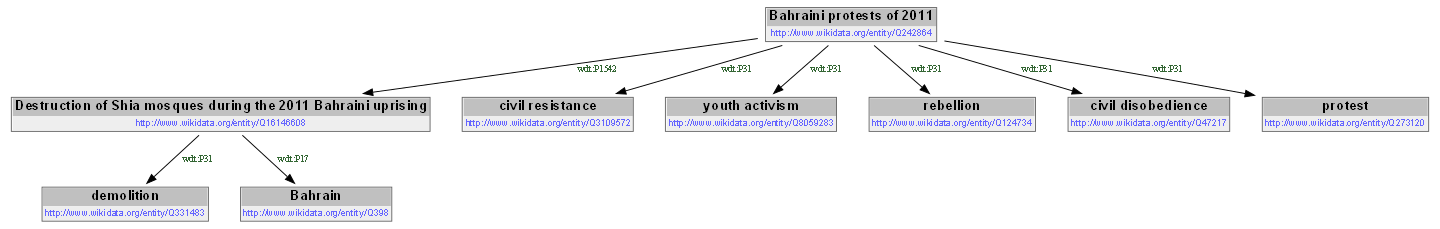

2019–21 Chilean protests -> Chilean national plebiscite, 2020


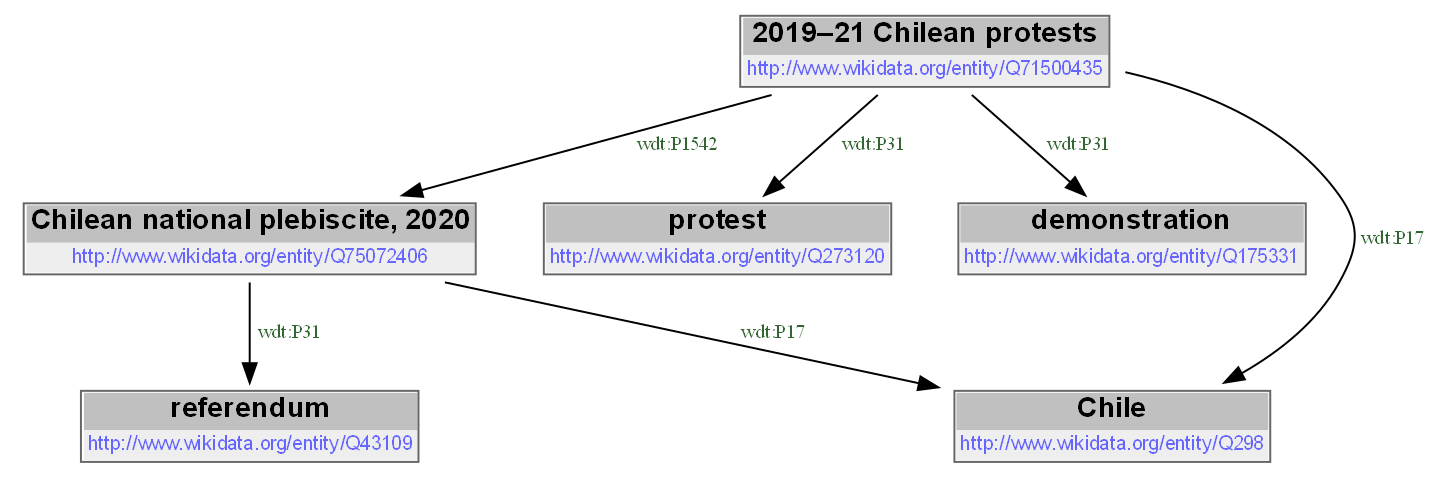

COVID-19 pandemic -> 2021 Cuban protests


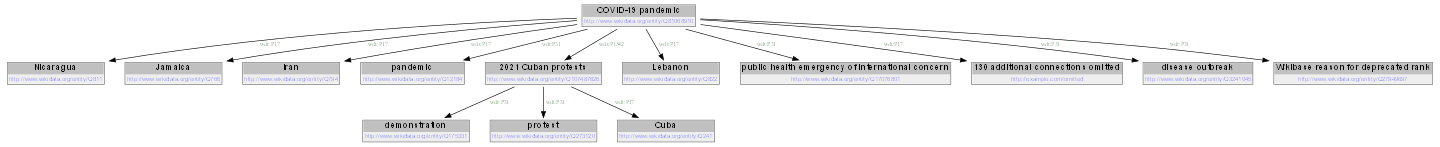

Iranian Revolution -> 1979 energy crisis


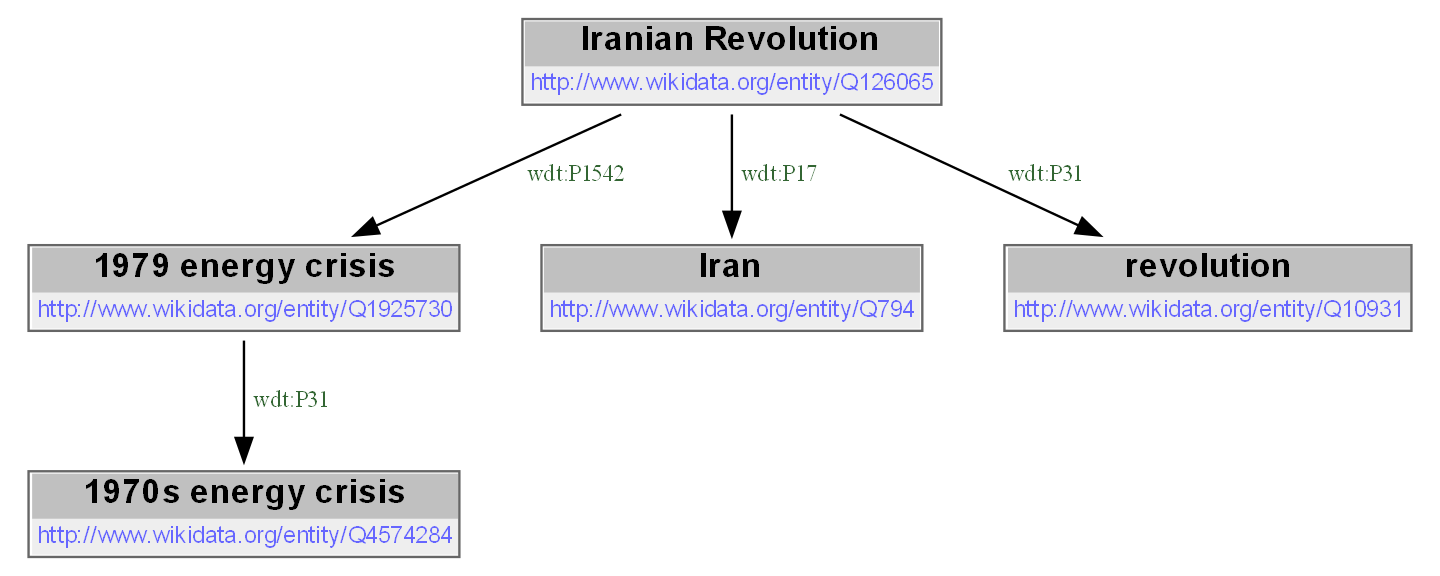

In [14]:
from visualizations.vis_cases import *
supporting_cases2 = forward_res2.similar_cause_effect_pairs
for i in range(4):
    print(full_kg.value(subject=supporting_cases2[i].cause, predicate=RDFS.label), "->",
          full_kg.value(subject=supporting_cases2[i].effect, predicate=RDFS.label))
    imname = f'ir_{i}.png'
    visualize_supporting_case(c=supporting_cases2[i], kg=full_kg, connecting_prop=WDT_HASEFFECT,
                         cause_props=[p_instanceOf, p_country], effect_props=[p_instanceOf, p_country],
                              imname=imname,
                              workaround_country=ent_country2)

Several example cases drawn from the KG appear to be very relevant to our new event, such as the
Bahraini protests, Chilean protests, and Iranian Revolution. The Bahraini protests appeared to be the most similar
to our new event, given that it had an exact match to the type of cause event and because Bahrain is more similar to
Iran than Chile.

We also see an example of a somewhat less desirable case, which is largely an artifact of how Wikidata is
currently populated. The COVID-19 pandemic, and a Cuban protest caused by the pandemic, are listed among the
similar cases used in this example. Wikidata's entry for COVID-19 lists over 100 countries which were affected, which
leads to this event having a match for the country Iran with our new Cause event. Arguably, the pandemic and its effects
may be relevant to considering what the effects of a new event in Iran are, but the breadth of this particular event is
not ideal.

This example demonstrates how (1) some peculiarities in the underlying KG can lead to odd choices of
cases that are retrieved, and (2) the availability of relevant events in the KG can limit how good the
"best" cases are.


The top predictions for the new Effect event's for our Protest in Iran example using the basic method are:


In [15]:
print("Top predictions for the effect event's country relation")
for (prediction, supp) in list(forward_res2.property_entity_support[p_country].items())[:7]:
    ent_label = full_kg.value(subject=prediction, predicate=RDFS.label)
    print(f"{ent_label} ({prediction})")
print("====")
print("Top predictions for the effect event's instanceOf relation")
for (prediction, supp) in list(forward_res2.property_entity_support[p_instanceOf].items())[:7]:
    ent_label = full_kg.value(subject=prediction, predicate=RDFS.label)
    print(f"{ent_label} ({prediction})")

Top predictions for the effect event's country relation
Iran (http://www.wikidata.org/entity/Q794)
Khorasan Province (http://www.wikidata.org/entity/Q6178890)
Sasanian Empire (http://www.wikidata.org/entity/Q83891)
Parthian Empire (http://www.wikidata.org/entity/Q1986139)
Qajar Iran (http://www.wikidata.org/entity/Q63158027)
Pahlavi Dynasty (http://www.wikidata.org/entity/Q207991)
Ba'athist Iraq (http://www.wikidata.org/entity/Q3108185)
====
Top predictions for the effect event's instanceOf relation
protest (http://www.wikidata.org/entity/Q273120)
rebellion (http://www.wikidata.org/entity/Q124734)
massacre (http://www.wikidata.org/entity/Q3199915)
youth activism (http://www.wikidata.org/entity/Q8059283)
civil resistance (http://www.wikidata.org/entity/Q3109572)
civil disobedience (http://www.wikidata.org/entity/Q47217)
human chain (http://www.wikidata.org/entity/Q1562095)


In [16]:

print("Refined predictions for the effect event's country relation")
for (prediction, supp) in reverse_res2.property_prediction_support[p_country][:7]:
    ent_label = full_kg.value(subject=prediction, predicate=RDFS.label)
    print(f"{ent_label} ({prediction})")
print("====")
print("Refined predictions for the effect event's instanceOf relation")
for (prediction, supp) in reverse_res2.property_prediction_support[p_instanceOf][:7]:
    ent_label = full_kg.value(subject=prediction, predicate=RDFS.label)
    print(f"{ent_label} ({prediction})")

Refined predictions for the effect event's country relation
Iran (http://www.wikidata.org/entity/Q794)
Iraq (http://www.wikidata.org/entity/Q796)
Azerbaijan (http://www.wikidata.org/entity/Q227)
Saudi Arabia (http://www.wikidata.org/entity/Q851)
United Arab Emirates (http://www.wikidata.org/entity/Q878)
Turkey (http://www.wikidata.org/entity/Q43)
Syria (http://www.wikidata.org/entity/Q858)
====
Refined predictions for the effect event's instanceOf relation
protest (http://www.wikidata.org/entity/Q273120)
demonstration (http://www.wikidata.org/entity/Q175331)
civil disorder (http://www.wikidata.org/entity/Q686984)
Quran desecration (http://www.wikidata.org/entity/Q7272924)
human chain (http://www.wikidata.org/entity/Q1562095)
rebellion (http://www.wikidata.org/entity/Q124734)
police brutality (http://www.wikidata.org/entity/Q1996993)


This time our refinement method seems to produce more convincing improvements to the predictions. In particular,
the predictions for the country using the basic prediction lead to some questionable results, such as
old empires, while the refined predictions list relevant countries like Iran, Iraq, and Azerbaijan.

The refinement for the instanceOf of the effect are slightly harder to judge, with both methods producing
some reasonable options such as how this event might lead to further protests, demonstrations, rebellion,
and police brutality.
